<a href="https://colab.research.google.com/github/JoseZamora97/cowntia/blob/main/CowntIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informe de Proyecto
- *Nombre*: **CowntIA**
- *Descripción*: Se desea desarrollar un algoritmo de Visión Artificial que estime la masa de ejemplares de ganado *vacuno* a través de imágenes.
- *Funcional*: Se busca que el sistema reciba como parámetros dos imágenes y sea capaz de:
    - Detectar la posición del ejemplar en la imagen.
    - Determinar la máscara que le recubre.
    - Determinar la orientación
    - Calcular puntos importantes A, B, C (más detalle en la implementación)
    - Aproximar el perímetro torácico a partir de C.
    - Calcular masa en función de los píxeles.

- *Desarrollador*: *Jose Miguel Zamora Batista*.

Tabla de productividad.

| # | Día | Horas | Hitos |
|:--:|:----|:-----:|:-----|
| 20  | L | 1 | Reunión, Envío de Tesis, Solicitud de Hito en Freelancer |
| 21  | M | 1 | |
| 22  | X | 2 | Inicio de Proyecto y Envío de Tareas, Confirmación de Hito |
| 23  | J | 2 | Informe de avances (I) |
| 24  | V | 5 | Envío de imágenes con avances |
| 25  | S | 9 | Informe de avances (II) y envío de imágenes con avances |
| 26  | D | 9 | Reunión, Envío de pdf con detalles,  |
| 27  | L | 0 | |
| 28  | M |  | Liberación de Hito, Envío de Código Fuente |
| Total\* | 9 | 29 | **Aproximado a la baja* |


# Información de la GPU

In [122]:
!nvidia-smi

Tue Sep 28 20:05:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    59W / 149W |   8948MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Conexión con Google Colab con Google Drive

Con este paso se accede a las imágenes en Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instalación de librerías necesarias

Para visualizar las imágenes con las cajas detectadas, los puntos clave y la segmentación adecuados, utilizaremos la API de detección de objetos de TensorFlow. Para instalarla clonaremos el repo.

Intalación de librerías necesarias.

In [3]:
# Forzar a Colab a usar Tensorflow 2.5
!pip install -U tensorflow>=2.5 >> /dev/null
# Clonar el repositorio
!git clone --depth 1 https://github.com/tensorflow/models >> /dev/null
# Libreria de manipulación de imágenes
!pip install --upgrade imutils >> /dev/null

Cloning into 'models'...
remote: Enumerating objects: 2924, done.
remote: Counting objects: 100% (2924/2924), done.
remote: Compressing objects: 100% (2463/2463), done.
remote: Total 2924 (delta 739), reused 1245 (delta 423), pack-reused 0
Receiving objects: 100% (2924/2924), 33.00 MiB | 448.00 KiB/s, done.
Resolving deltas: 100% (739/739), done.


Instalación de la API de Detección de Objetos de Tensorflow Hub




In [4]:
%%bash
sudo apt install -y protobuf-compiler >> /dev/null
cd models/research/
protoc object_detection/protos/*.proto --python_out=. >> /dev/null
cp object_detection/packages/tf2/setup.py . >> /dev/null
python -m pip install . >> /dev/null



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Importación de librerías

In [5]:
import os
import numpy as np
import cv2 as cv

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from imutils import perspective
from matplotlib.patches import Ellipse
from scipy.signal import find_peaks
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

Función de Utilidad para mostrar un par de imágenes

In [124]:
def imshow_front_side(im_f, im_s, title, figsize=(12, 6), cmap='viridis', axis=False):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    fig.suptitle(title)
    
    ax1.set_title("Frontal"); ax2.set_title("Lateral")
    ax1.imshow(im_f, cmap=cmap); ax2.imshow(im_s, cmap=cmap)
    
    if not axis:
        ax1.axis('off'); ax2.axis('off')
    plt.show()

## Segmentación semántica con Mask-RCNN

In [125]:
model = 'Mask R-CNN Inception ResNet V2 1024x1024'
m_url = 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'

print('Más información del modelo en TensorFlow Hub: {}'.format(m_url))

Más información del modelo en TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1


### Cargar los datos del mapa de etiquetas (para la visualización).

Los mapas de etiquetas corresponden a los números de índice con los nombres de las categorías, de modo que cuando nuestra red de convolución predice "5", sabemos que corresponde a "avión". En este caso, sería el número "21" el que indique se ha detectado un animal vacuno ("cow", en inglés).

In [126]:
#@markdown
class Category:
    cow = {21: {'id': 21, 'name': 'cow'}}
    categories = [cow, ]

    @classmethod
    def get_cat_index(cls):
        return {list(c.keys())[0]:list(c.values())[0] 
                for c in cls.categories}

In [127]:
category_index = Category.get_cat_index()

### Cargar el modelo desde TensorFlow Hub

Aquí sólo necesitamos el handle del modelo que fue seleccionado y usamos la librería Tensorflow Hub para cargarlo en memoria.


In [129]:
print('Cargando el modelo...')
hub_model = hub.load(m_url)
print(f'Modelo {model} cargado!')

Cargando el modelo...
Modelo Mask R-CNN Inception ResNet V2 1024x1024 cargado!


### Cargar imágenes

Para cargar imágenes se pretende una carga por pares (imagen frontal e imagen lateral). Para ello se necesitará especificar la ruta del directorio contenedor de las imágenes.



In [130]:
#@markdown
def draw_mark(input_image, size_rate=0.02):
    im = input_image.copy()
    h, w, _ = im.shape
    
    size = int(w * size_rate) # 2% of the widht by default.
    row = int(h - size - size//2)
    col = int(size//2)

    im_out = cv.rectangle(im, (row, col), (row+size, col+size), (0, 0, 255), -1)

    return im_out


def load_images(path, add_mark=True, mark_size=0.02):
    assert os.path.exists(path), "No existe la ruta"
    assert os.path.isdir(path), "No es una carpeta"
    assert len(os.listdir(path)), "No hay dos imágenes en la carpeta"

    im_f = cv.cvtColor(cv.imread(f"{path}/frontal.jpg"), cv.COLOR_BGR2RGB)
    im_s = cv.cvtColor(cv.imread(f"{path}/lateral.jpg"), cv.COLOR_BGR2RGB)
    
    if add_mark:
        im_s = draw_mark(im_s, mark_size)

    return im_f, im_s

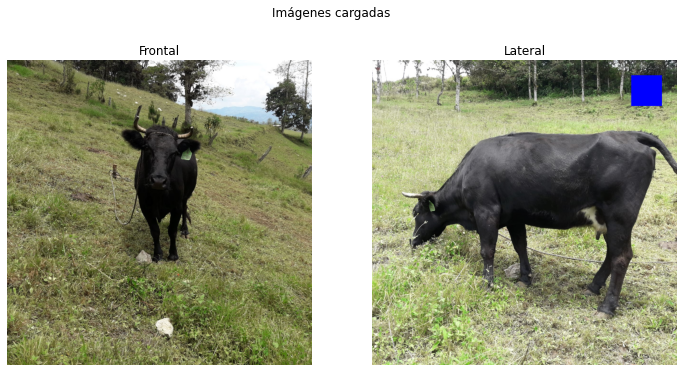

In [193]:
#@markdown Introduce a continuación la ruta de la carpeta que contiene el par de imágenes `frotal` y `lateral`.

RUTA = "/content/drive/MyDrive/freelancer/samples_cow/1" #@param {type:"string"}

#@markdown Debido a que para estimar una medición de la masa correcta es necesario contar con una herramienta que permita saber cuantos píxeles equivalen $x$ medida en el mundo real.
#@markdown A continuación se elige el porcentaje de la imagen que ocupará la máscara.
TAMAÑO_MASCARA = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}

im_f, im_s = load_images(RUTA, True, TAMAÑO_MASCARA)

im_f = im_f.reshape((1, *im_f.shape))
im_s = im_s.reshape((1, *im_s.shape))

imshow_front_side(im_f[0], im_s[0], "Imágenes cargadas", figsize=(12, 6))

## Haciendo la inferencia

Para hacer la inferencia sólo tenemos que llamar a nuestro modelo cargado de TF Hub.

Cosas que puedes probar:
* Imprimir `resultado['cajas_detección']` e intentar hacer coincidir las ubicaciones de las cajas con las cajas de la imagen.  Observa que las coordenadas se dan en forma normalizada (es decir, en el intervalo [0, 1]).
* Inspeccionar otras claves de salida presentes en el resultado. Una documentación completa se puede ver en la página de documentación de los modelos (apuntando su navegador al mango del modelo impreso anteriormente)*

In [194]:
front_results_raw = hub_model(im_f)
side_results_raw = hub_model(im_s)

In [195]:
front_result = {key:value.numpy() for key, value in front_results_raw.items()}
side_result = {key:value.numpy() for key, value in side_results_raw.items()}

## Visualización de los resultados

Aquí es donde necesitaremos la API de detección de objetos de TensorFlow para mostrar los cuadrados del paso de inferencia (y los puntos clave cuando estén disponibles). La documentación completa de este método puede verse [aquí](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py)

Aquí puedes, por ejemplo, establecer `min_score_thresh` a otros valores (entre 0 y 1) para permitir que entren más detecciones o para filtrar más detecciones.

Función de Utilidad `show_bbox` para mostrar los bboxes detectados.

In [196]:
#@markdown
def show_bbox(image_np, result):

    label_id_offset, im_out = 0, image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        im_out[0], result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index, use_normalized_coordinates=True,
        max_boxes_to_draw=1, min_score_thresh=.30,
        agnostic_mode=False)

    return im_out.reshape((im_out.shape[1:]))

Mostrando la detección realizada.

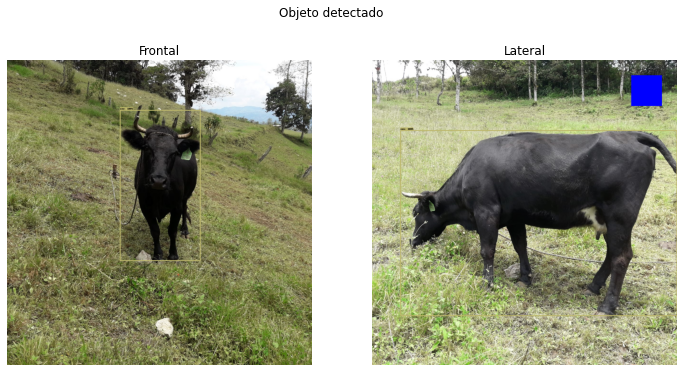

In [197]:
im_out_f = show_bbox (im_f, front_result )
im_out_s = show_bbox (im_s, side_result  )

imshow_front_side(im_out_f, im_out_s, "Objeto detectado", figsize=(12, 6))

## Obtención de máscaras

Entre los modelos de detección de objetos disponibles está Mask R-CNN y la salida de este modelo permite la segmentación de instancias.

Para visualizarlo utilizaremos el mismo método que antes pero añadiendo un parámetro adicional: `instance_masks=output_dict.get('detection_masks_reframed', None)`.

Función de Utilidad `show_masks` para mostrar la imagen con la máscara de segmentación.

In [198]:
#@markdown
def show_masks(image_np, result):
    
    label_id_offset, im_out = 0, image_np.copy()

    if 'detection_masks' in result:
        # we need to convert np.arrays to tensors
        detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
        detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                detection_masks, detection_boxes,
                image_np.shape[1], image_np.shape[2])
    
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
    result['detection_masks_reframed'] = detection_masks_reframed.numpy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        im_out[0], result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index, use_normalized_coordinates=True,
        max_boxes_to_draw=1, min_score_thresh=.30,agnostic_mode=False,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=8,
        skip_boxes=True, skip_scores=True, 
        skip_labels=True,skip_track_ids=True)

    return im_out.reshape((im_out.shape[1:]))

Muestra de la imagen con la máscara.

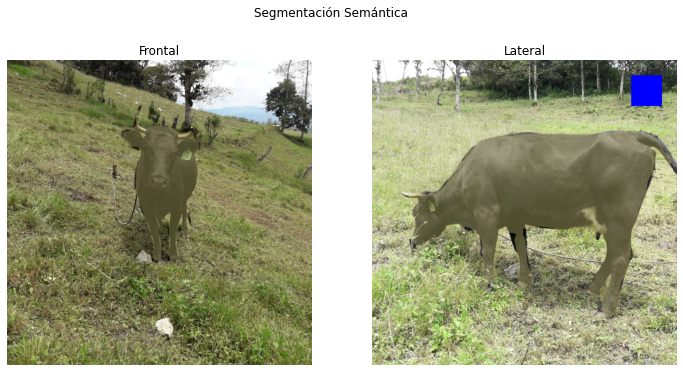

In [199]:
im_mask_f = show_masks(im_f, front_result)
im_mask_s = show_masks(im_s, side_result)

imshow_front_side(im_mask_f, im_mask_s, "Segmentación Semántica", figsize=(12, 6))

# Algoritmo para calular masa vacuna sin báscula

### Extracción de máscaras

In [200]:
#@markdown
def get_mask(im, result):
    zeros = np.zeros_like(im)
    mask = show_masks(zeros, result)

    mask = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    (ths, im_bin) = cv.threshold(mask, 128, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)

    return im_bin

# Mappeo de opciones para generar kernels.
def morph_shape(val):
    if val == 0:
        return cv.MORPH_RECT
    elif val == 1:
        return cv.MORPH_CROSS
    elif val == 2:
        return cv.MORPH_ELLIPSE

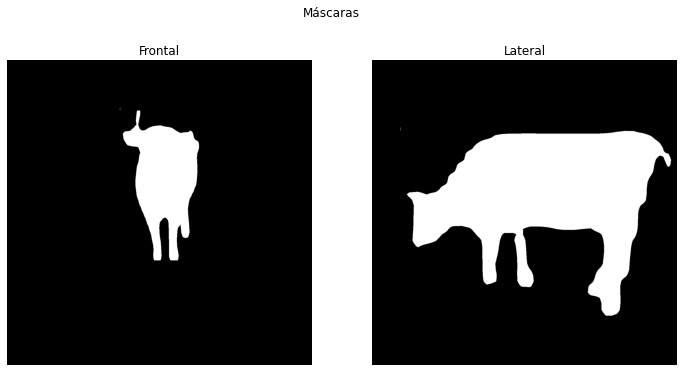

In [201]:
mask_f = get_mask(im_f, front_result)
mask_s = get_mask(im_s, side_result )

imshow_front_side(mask_f, mask_s, "Máscaras", figsize=(12, 6), cmap='gray')

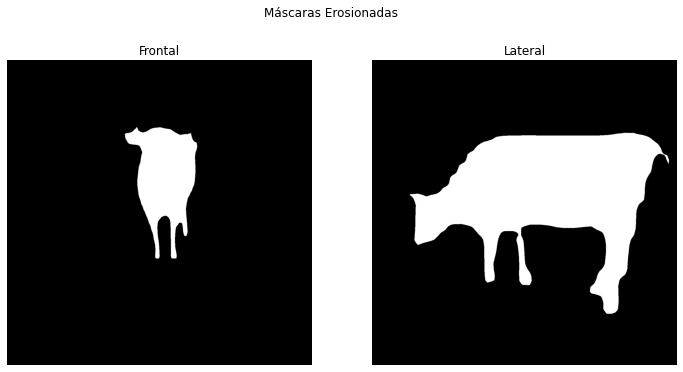

In [202]:
#@markdown Preprocesamiento de la máscara
kernel = morph_shape(2)
erosion_size = 4 #@param {type:"slider", min:0, max:5, step:1}
iterations = 2 #@param {type:"slider", min:1, max:3, step:1}

use_eroded = True #@param {type:"boolean"}

element = cv.getStructuringElement(kernel, 
                                   (2*erosion_size + 1, 2*erosion_size+1), 
                                   (erosion_size, erosion_size))
eroded_f = cv.erode(mask_f, element, iterations=iterations)
eroded_s = cv.erode(mask_s, element, iterations=iterations)

imshow_front_side(eroded_f, eroded_s, "Máscaras Erosionadas", figsize=(12, 6), cmap='gray')

if use_eroded:
    mask_f = eroded_f
    mask_s = eroded_s

## Detección de orientación y Extracción de Histogramas

In [203]:
#@markdown
def get_contours(m):
    mask = m.copy()

    contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    im_show = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    c = max(contours, key = cv.contourArea)
    cv.drawContours(im_show, [c], 0, (0, 255, 255), 2, cv.LINE_8, 4, 0)

    return c, im_show 


def get_bound_rect(contour, shape):
    contours_poly = cv.approxPolyDP(contour, 3, True)
    x, y, w, h = bound_rect = cv.boundingRect(contours_poly)

    im_show = cv.rectangle(np.zeros(shape), 
                            (int(x), int(y)), (int(x+w), int(y+h)), 
                            (255, 255, 0), 2)

    return bound_rect, im_show


def get_deformation(bound_rect_f, bound_rect_s):
    # Se extrae la medida de la altura de llegada (máscara frontal)
    _, _, widht_tar, height_tar = bound_rect_f
    # Se calcula la razon de aspecto de llegada
    tar_ratio_old = widht_tar / height_tar
    # Se extrae la medida de la altura de partida (máscara lateral)
    _, _, width_src, height_src = bound_rect_s

    # Calcular el ratio de diferencia
    diff_h = height_src - height_tar
    ratio = diff_h / height_tar

    # Calcular el nuevo tamaño de la imagen
    h, w = im_show_f.shape
    new_size = (int(w + (w * ratio)), int(h + (h * ratio)))

    return ratio, new_size

Para detectar la dirección hacia donde mira el animal es necesario:

* Calcular el contorno de la máscara lateral.
* Calcular el rectángulo mínimo de los contornos.
* Extraer la sección de la máscara lateral marcada por el rectángulo.
* Calular histogramas y tomar decisión base a ellos.



### Cálculo de contorno de máscara lateral

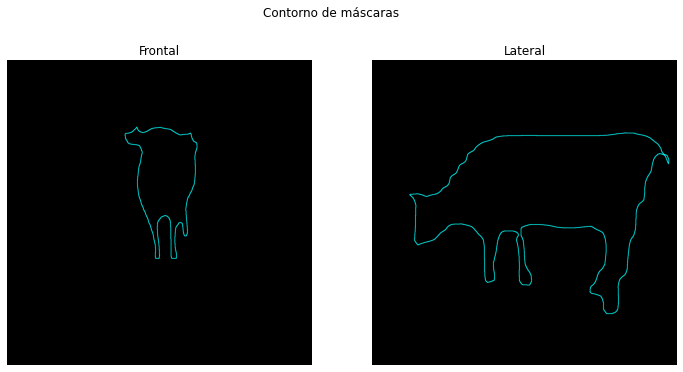

In [204]:
mask_s_ = mask_s.copy()
mask_f_ = mask_f.copy()

countour_f, im_show_f = get_contours(mask_f_)
countour_s, im_show_s = get_contours(mask_s_)

imshow_front_side(im_show_f, im_show_s, "Contorno de máscaras", figsize=(12, 6), cmap='gray')

### Cálculo del rectángulo mínimo de los contornos

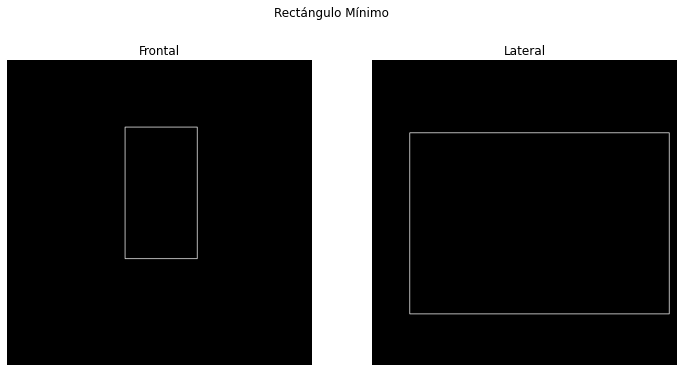

In [205]:
bound_rect_f, im_show_f = get_bound_rect(countour_f, mask_s_.shape)
bound_rect_s, im_show_s = get_bound_rect(countour_s, mask_f_.shape)

imshow_front_side(im_show_f, im_show_s, "Rectángulo Mínimo", figsize=(12, 6), cmap='gray')

### Extracción y alineación de máscaras.

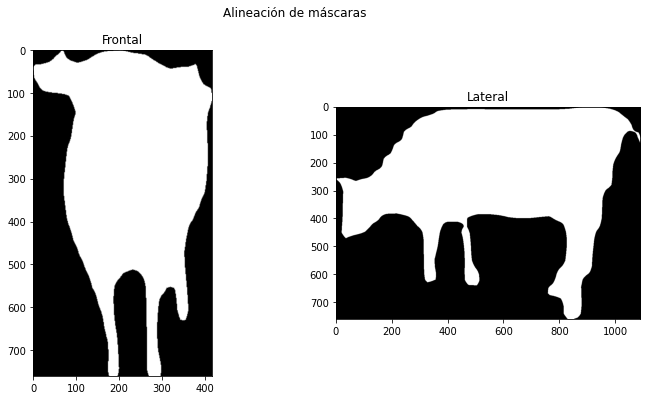

In [206]:
x, y, w, h = bound_rect_s
mask_cropped = mask_s_[y:y+h,x:x+w]
x, y, w, h = bound_rect_f
mask_front_cropped = mask_f_[y:y+h,x:x+w]

ratio, size = get_deformation(bound_rect_f, bound_rect_s)

h, w = mask_front_cropped.shape
size = (int(w + (w * ratio)), int(h + (h * ratio)))
resized = cv.resize(mask_front_cropped, size)
imshow_front_side(resized, mask_cropped, "Alineación de máscaras", 
                  figsize=(12, 6), cmap='gray', axis=True)

### Cálculo de histogramas

Los histogramas ayudan a ver la distribución de píxeles activos en una imagen. A partir de ellos se pueden detectar partes importantes.
Para determinar una posición en una imagen es necesario analizar tanto el histograma horizonal (media de las columnas), como el vertical.


In [207]:
#@markdown
def get_histograms(mask_cropped, search=0.12):
    
    hscatter = np.mean(mask_cropped, axis=0)/255.
    vscatter = np.mean(mask_cropped, axis=1)/255.

    crop = int(search * hscatter.size)
    crop_ = hscatter.size - crop

    return (hscatter, vscatter), (crop, crop_)

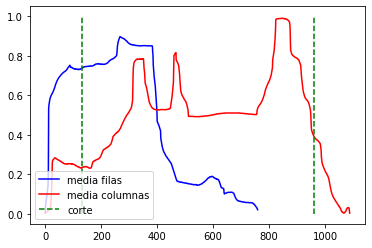

In [208]:
(hscatter, vscatter), (crop, crop_) = get_histograms(mask_cropped, search=0.12)

left = hscatter[:crop]
right = hscatter[crop_:]

plt.plot(vscatter, 'b', label='media filas')
plt.plot(hscatter, 'r', label='media columnas')
plt.plot([crop, crop], [0.0, 1.0], 'g--', label='corte')
plt.plot([crop_, crop_], [0.0, 1.0], 'g--')
plt.legend(); plt.show()

### Dirección en base a reglas
A partir del histograma horizontal se puede define ver que la
distribución de píxeles cuando el animal mira a la derecha es menor
en dicho lado.

In [209]:
left_direction = hscatter[crop] < hscatter[crop_]
right_direction = not left_direction

In [210]:
print("Dirección izquierda:", left_direction)
print("Dirección derecha:", right_direction)

Dirección izquierda: True
Dirección derecha: False


## Detección de Puntos Importantes

Para el cálculo de la masa de ejemplares vacunos, es necesario calcular 3 puntos principales. ($A$, $B$, $C$ según imagen, explicación [aquí](https://inovagro.com/como-calcular-el-peso-del-ganado-sin-bascula/)).

Con la distancia $\overline{AB}$ tenemos la distancia que determina el *Largo del Cuerpo* $LC$. Con el segmento que pasa por $C$ se puede aproximar una elipsis cuyo arco determine el *Perímetro Torácico* $PC$. Una vez se tienen dichas distancias, se puede aproximar la masa del animal siguiendo la ecuación:

$$Masa\ =\ \frac{PT^{2} \ast LC}{10838}$$

Donde las medidasd $PT$ y $LC$ están en centímetros.


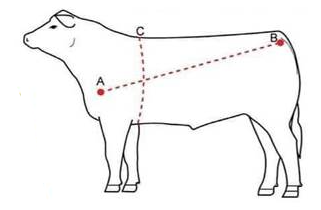

Ciertas medidas se tomaron basadas en las proporciones detalladas en este [estudio](http://www.omafra.gov.on.ca/english/livestock/dairy/facts/freestaldim.htm).

La siguiente imagen muestra algunas de las proporciones del estudio.

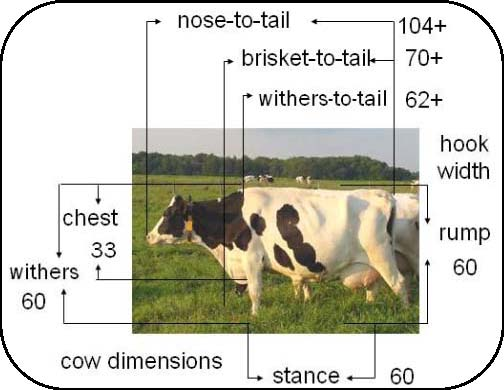

In [211]:
# Parámetros de configuración

# Mínima distancia entre picos 
# (ayuda a filtrar picos consecutivos)
MIN_DISTANCE = 100

# Valores extraidos del estudio para calcular
# la relación Pecho/Altura.
CHEST, WITHERS = 33, 60
THRESHOLD = CHEST / WITHERS

# Longitud de la curva donde buscar el 
# cambio de curvatura.
SEARCH_CURVE = 80

#### Detección de las patas del animal
Siguiendo el histograma horizontal es posible determinar la posición
de las patas viendo los picos más elevados.

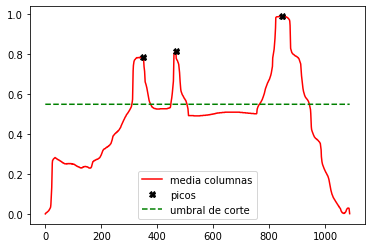

In [212]:
#@markdown
peaks, _ = find_peaks(hscatter, height=THRESHOLD, distance=MIN_DISTANCE)

plt.plot(hscatter, 'r-', label='media columnas')
plt.plot(peaks, hscatter[peaks], "kX", label='picos')
plt.plot(np.zeros_like(hscatter) + THRESHOLD, "g--", label='umbral de corte')
plt.legend(); plt.show()

### Detección del Punto $C(x, y)$

#### Coordenada $C_{x}$

El cálculo de la coordenada $C_{x}$ está basado en la posición de la 
pata delantera $(x_{pata})$ del animal. Teniendo dicha posición calculada anteriormente, lo que se busca es el punto de cambio de curvatura de la función $(H_{hor}(x))$ que el histograma píxeles posteriores a la pata, en una ventana de busqueda definida $(w)$.

Se tiene entonces:

- $Si\ dir = izquierda$:
    1. $z \leftarrow [x_{pata}, x_{pata} + w)$
    2. $y \leftarrow H_{hor}[[x_{pata}, x_{pata} + w)]$
    3. $m \leftarrow \frac{{z}'}{{y}'}$
    4. $i \leftarrow {m}' \neq 0$
    5. $c_x \leftarrow argmin(H_{hor}[i_1 + x_{pata}]) + x_{pata}$

- $Si\ dir = derecha$:
    1. $z \leftarrow [x_{pata} - w, x_{pata})$
    2. $y \leftarrow H_{hor}[[x_{pata} - w, x_{pata})]$
    3. $m \leftarrow \frac{{z}'}{{y}'}$
    4. $i \leftarrow {m}' \neq 0$
    6. $c_x \leftarrow x_{pata} - argmin(H_{hor}[i_1 + x_{pata}])$

In [213]:
#@markdown
def compute_cx(hscatter, peaks, left_direction):
    if left_direction:
        peak = peaks[0]
        x = np.linspace(peak, peak+SEARCH_CURVE, SEARCH_CURVE)
        y = hscatter[peak:peak+SEARCH_CURVE]
        m = np.diff(y) / np.diff(x)
        idx = np.where(np.diff(m))[0]
        cx = np.argmin(hscatter[idx + peak]) + peak

    else:
        peak = peaks[-1]
        x = np.linspace(peak - SEARCH_CURVE, peak, SEARCH_CURVE)
        y = hscatter[peak-SEARCH_CURVE:peak]
        m = np.diff(y) / np.diff(x)
        idx = np.where(np.diff(m))[0]
        cx = peak - np.argmin(hscatter[peak - idx])

    return cx

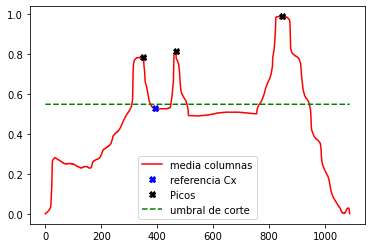

In [214]:
cx = compute_cx(hscatter, peaks, left_direction)

plt.plot(hscatter, 'r-', label='media columnas')
plt.plot(cx, hscatter[cx], "bX", label='referencia Cx')
plt.plot(peaks, hscatter[peaks], "kX", label='Picos')
plt.plot(np.zeros_like(hscatter) + THRESHOLD, "g--", label='umbral de corte')
plt.legend(); plt.show()

#### Coordenada $C_{y}$

Siguiendo con el estudio de las proporciones y utilizando el histograma
vertical $(H_{ver}(x))$:
- $c_y \leftarrow \frac{chest}{withers} * n \ |\ H_{ver} \mapsto (h_1, h_2, ..., h_n) $ 


In [215]:
def compute_cy(vscatter):
    cy = int(vscatter.size * THRESHOLD)
    return cy

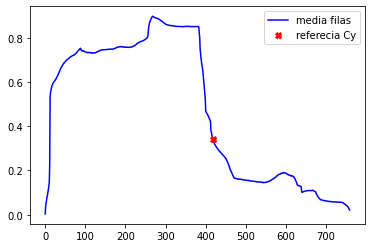

In [216]:
cy = compute_cy(vscatter)

plt.plot(vscatter, 'b-', label='media filas')
plt.plot(cy, vscatter[cy], 'rX', label='referecia Cy')
plt.legend(); plt.show()

#### Punto $C(x, y)$

In [217]:
#@markdown
C = (cx, cy)
print('Punto C(x, y) =', C)

Punto C(x, y) = (393, 418)


### Detección del Punto $B(x, y)$

#### Coordenada $B_y$

Para el cálculo de la coordenada $x$ del punto $B$ consiste en predeterminar un ratio `CUT_OFF` que indique de forma proporcional donde se encontraría el punto $B$.

Bastaría con calcular el índice teniendo en cuenta la longitud de la máscara $(L_x)$, la orientación $(dir)$ y dicho ratio $(r)$.

- $Si\ dir =\ derecha:\ b_{x} \leftarrow L_x\ r$
- $Si\ dir =\ izquierda:\ b_{x} \leftarrow L_x\ -(L_x\ r)$


In [218]:
#@markdown
def compute_bx(hscatter, left_direction, CUT_OFF_X = 0.05):
    if left_direction:
        return int(hscatter.size - (hscatter.size * CUT_OFF_X))
    else:
        return int(hscatter.size * CUT_OFF_X)

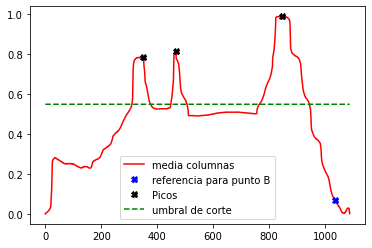

In [219]:
bx = compute_bx(hscatter, left_direction, CUT_OFF_X = 0.05)

plt.plot(hscatter, 'r-', label='media columnas')
plt.plot(bx, hscatter[bx], "bX", label='referencia para punto B')
plt.plot(peaks, hscatter[peaks], "kX", label='Picos')
plt.plot(np.zeros_like(hscatter) + THRESHOLD, "g--", label='umbral de corte')
plt.legend(); plt.show()

#### Coordenada $B_y$

Para calcular esta coordenada se tiene 
en cuenta el inicio de la máscara. Para 
ello, se define un ratio `CUT_OFF` muy bajo.

El valor de esta coordenada está 
determinado por la longitud vertical $(L_y)$ y el ratio $(r)$.

- $b_{y} \leftarrow L_y\ r$

In [220]:
#@markdown
def compute_by(vscatter, CUT_OFF_Y=0.02):
    return int(vscatter.size * CUT_OFF_Y)

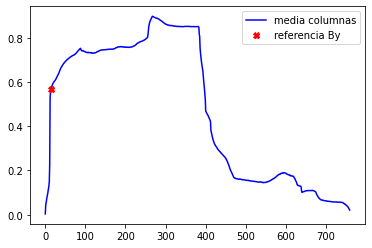

In [221]:
by = compute_by(vscatter, CUT_OFF_Y=0.02)

plt.plot(vscatter, 'b-', label='media columnas')
plt.plot(by, vscatter[by], "rX", label='referencia By')
plt.legend(); plt.show()

In [222]:
#@markdown #### Punto $B(x, y)$

B = (bx, by)
print('Punto B(x, y) =', B)

Punto B(x, y) = (1034, 15)


### Detección del Punto $A(x, y)$

#### Coordenada $A_{x}$

Para detectar la coordenada $x$ del 
punto $A$ es necesario calcular el índice 
mediano entre la pata $(x_{pata})$ más delantera y el punto de detección de la cabeza $(x_{cabeza})$.

Se tiene entonces:
- $Si\ dir = izquierda:$
    - $r \leftarrow [x_{cabeza}, x_{pata})$
    - $a_x \leftarrow \mu_{1/2}(r)$
- $Si\ dir = derecha:$
    - $r \leftarrow [x_{pata}, x_{cabeza})$
    - $a_x \leftarrow \mu_{1/2}(r)$

In [223]:
#@markdown
def compute_ax(left_direction, crop, peak):
    if left_direction:
        return int(np.median(list(range(crop, peak))))
    else:
        return int(np.median(list(range(peak, crop)))) 

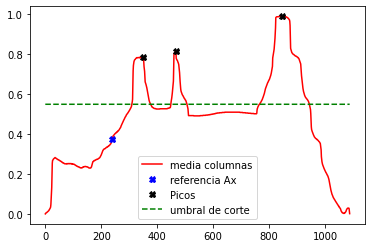

In [224]:
crp = crop if left_direction else crop_
peak = peaks[0] if left_direction else peaks[-1]
ax = compute_ax(left_direction, crp, peak)

plt.plot(hscatter, 'r-', label='media columnas')
plt.plot(ax, hscatter[ax], "bX", label='referencia Ax')
plt.plot(peaks, hscatter[peaks], "kX", label='Picos')
plt.plot(np.zeros_like(hscatter) + THRESHOLD, "g--", label='umbral de corte')
plt.legend(); plt.show()

#### Coordenada $A_y$
La coordenada $x$ del punto $A$ coincide con la anchura del pecho. Por tanto,
- $a_y \leftarrow c_y$  

In [225]:
#@markdown
def compute_ay(vscatter):
    return compute_cy(vscatter)

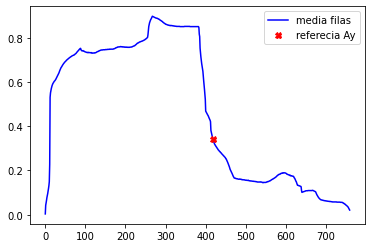

In [226]:
ay = compute_ay(vscatter)

plt.plot(vscatter, 'b-', label='media filas')
plt.plot(ay, vscatter[ay], 'rX', label='referecia Ay')
plt.legend(); plt.show()

In [227]:
#@markdown #### Punto $A(x, y)$ 
A = (ax, ay)
print("Punto A(x, y) = ", A)

Punto A(x, y) =  (240, 418)


#### Visualización de los puntos importantes

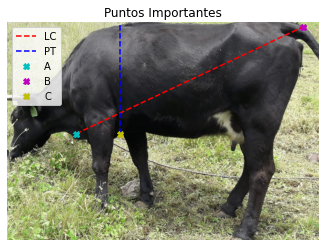

In [228]:
#@markdown
x, y, w, h = bound_rect_s
im_crop = im_s[0][y:y+h,x:x+w]

ax_, ay_ = A
bx_, by_ = B
cx_, cy_ = C

CORRECTION = 0.07

ay_ -= ay_ * CORRECTION
cy_ -= cy_ * CORRECTION

plt.imshow(im_crop)

plt.plot([ax_, bx_], [ay_, by_], 'r--', label='LC')
plt.plot([cx_, cx_], [cy_, 0], 'b--', label='PT')

plt.plot(ax_, ay_, 'cX', label='A')
plt.plot(bx_, by_, 'mX', label='B')
plt.plot(cx_, cy_, 'yX', label='C')

plt.title('Puntos Importantes')
plt.legend()
plt.axis('off'); plt.show()

## Aproximación del Perímetro del Tronco $(PT)$



#### Cálculo del *Diámetro 1*

Para el cálculo de este diametro basta con trazar una recta desde el el punto $C(x, y)$ hasta el final de la máscara $(M)$. Este otro punto $(C_{aux})$ será:

1. $c_{x_{aux}} \leftarrow c_x $
2. $l \leftarrow M_{i, c_x} \forall i \in {1, 2, ..., n}$
3. $c_{y_{aux}} \leftarrow l^{\ast}_{1}$
4. $C_{aux} \leftarrow (c_{x_{aux}}, c_{y_{aux}})$

El diámetro queda determinado por el segmento $\overline{CC_{aux}}$


In [229]:
#@markdown
def compute_d1(mask_cropped, C):
    cx, cy = C
    cy_line = mask_cropped[:, cx]
    cy_aux = np.where(cy_line)[0][0]
    C_aux = (cx, cy_aux)
    
    return (C, C_aux)

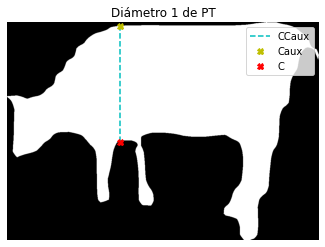

In [230]:
diameter_1 = compute_d1(mask_cropped, C)
cx, cy_aux = diameter_1[1]

plt.imshow(mask_cropped, cmap='gray')
plt.plot([cx, cx], [cy, cy_aux], 'c--', label='CCaux')
plt.plot(cx, cy_aux, 'yX', label='Caux')
plt.plot(cx, cy, 'rX', label='C')
plt.title('Diámetro 1 de PT'); plt.legend()
plt.axis('off'); plt.show()

#### Cálculo del *Diámetro 2*

Para calcular este diámetro es necesario, en primer lugar, determinar el los picos del histograma horizontal $(H_{hor}(x))^{top}$ de la máscara frontal. A partir de dichos picos se puede extrar pico más interesante, que determinará la altura a que se se situará el diámetro 2.

Dicho pico sera:
1. $a \leftarrow \left | H_{hor}(x))^{top}_i - \bar{X}(H_{hor}(x))^{top}) \right |$
2. $y \leftarrow min(a)$

El diámetro se define con dos puntos, de los cuales sabemos su coordenada $y$ (antes calculada). Con esta, y la máscara frontal $(M)$ es posible calcular las dos coordenadas $x$ necesarias. Para ello se definen dos puntos: $P(x, y) = (x_p, y)$ y $Q(x, y) = (x_q, y)$.

Con ellos se calculan $x_p$ y $x_q$.

1. $l \leftarrow M_{y, i} \forall i \in {1, 2, ..., n}$
2. $x_p \leftarrow l^{\ast}_{1}$
3. $x_q \leftarrow l^{\ast}_{n}$


In [231]:
#@markdown
def compute_d2(resized):
    vscatter = np.mean(resized, axis=1)/255.
    peaks, _ = find_peaks(vscatter, 
                        THRESHOLD, 
                        distance=vscatter.size * 0.2)

    mean = np.mean(peaks)
    y = min(peaks, key=lambda x: abs(x-mean))

    line = resized[y, :]
    line = np.where(line)[0]
    x_p, x_q = line[0], line[-1]

    P = (x_p, y)
    Q = (x_q, y)

    return (P, Q), (vscatter, peaks)

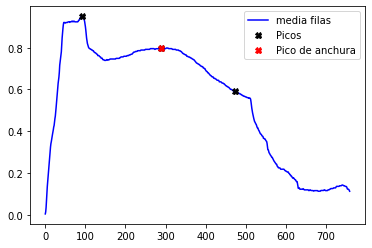

In [232]:
diameter_2, debug = compute_d2(resized)
vscatter_f, peaks = debug

x_p, y = diameter_2[0] # P
x_q, y = diameter_2[1] # Q

plt.plot(vscatter_f, 'b', label='media filas')
plt.plot(peaks, vscatter_f[peaks], "kX", label='Picos')
plt.plot(y, vscatter_f[y], "rX", label='Pico de anchura')
plt.legend(); plt.show()

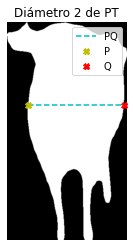

In [233]:
x = [x_p, x_q]

plt.imshow(resized, cmap='gray')
plt.plot(x, [y, y], 'c--', label='PQ')
plt.plot(x_p, y, 'yX', label='P')
plt.plot(x_q, y, 'rX', label='Q')

plt.title('Diámetro 2 de PT'); plt.legend()
plt.axis('off'); plt.show()

#### Visualización de Diámetros y Ellipsis

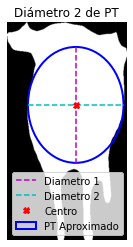

In [234]:
#@markdown
m = np.mean(x)

disth = abs(x_p - x_q)
distv = abs(cy - cy_aux)
top, bot = y - distv/2, y + distv/2

ellipse = Ellipse(xy=(m, y), edgecolor='b', fc='None', lw=2, 
                  label='PT Aproximado',
                  width=disth, height=distv)

_, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(resized, cmap='gray')
ax.add_patch(ellipse)
ax.plot([m, m] , [top, bot], 'm--', label='Diametro 1')
ax.plot(x, [y, y], 'c--', label='Diametro 2')
ax.plot(m, y, 'rX', label='Centro')

plt.title('Diámetro 2 de PT'); plt.legend()
plt.axis('off'); plt.show()

## Detección de plantilla de medición

Se procede a detectar la marca colocada al inicio del programa. Para ello se emplea un filtro de color HSV. Esta detección costa de 3 pasos:
- Estimar el rango de valores HSV que permiten detectar dicha marca generando una máscara.
- Calcular el contorno y mínimo rectángulo.
- Medir las dimensiones del rectángulo.

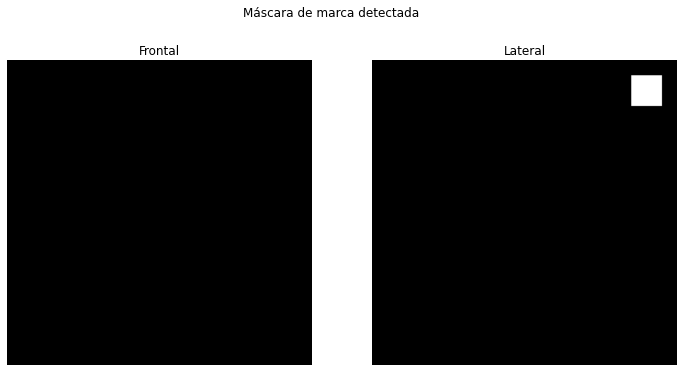

In [235]:
im_f_hsv = cv.cvtColor(im_f[0], cv.COLOR_RGB2HSV)
im_s_hsv = cv.cvtColor(im_s[0], cv.COLOR_RGB2HSV)

#@markdown Umbral en espacio HSV.
#@markdown - Límite inferior
lh = 60 #@param {type:"slider", min:0, max:180, step:1}
ls = 82 #@param {type:"slider", min:0, max:255, step:1}
lv = 140 #@param {type:"slider", min:0, max:255, step:1}

#@markdown - Límite superior
hh = 180 #@param {type:"slider", min:0, max:180, step:1}
hs = 255 #@param {type:"slider", min:0, max:255, step:1}
hv = 255 #@param {type:"slider", min:0, max:255, step:1}

lower = np.array([lh, ls, lv])
upper = np.array([hh, hs, hv])

# preparing the mask to overlay
mask_f_mark = cv.inRange(im_f_hsv, lower, upper)
mask_s_mark = cv.inRange(im_s_hsv, lower, upper)

imshow_front_side(mask_f_mark, mask_s_mark, "Máscara de marca detectada", 
                  figsize=(12, 6), cmap='gray')

#### Cálculo de longitud de máscara

Para realizar este cálculo se calcula el contorno y el rectángulo de área mínima. Una vez se tiene este, basta con calcular la longitud de un lado.

In [236]:
#@markdown
def get_size_of_mask(contour_m):
    
    box = cv.minAreaRect(countour_m)
    box = cv.boxPoints(box)
    box = perspective.order_points(box).astype(int)
    
    side = abs(box[0][0] - box[1][0])

    return side, box

#### Visualización de medición de marca detectada

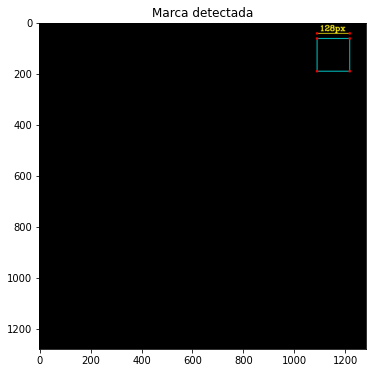

In [237]:
#@markdown
countour_m, im_cnt = get_contours(mask_s_mark)
side, box = get_size_of_mask(countour_m)

yellow = (255, 241, 19)
red = (255, 0, 0)

for x, y in box:
    cv.circle(im_cnt, (x, y), 5, red, -1)

a = (box[0][0], box[0][1] - 20)
b = (box[1][0], box[1][1] - 20)

cv.line(im_cnt, a, b, yellow, 2)
cv.circle(im_cnt, a, 5, red, -1)
cv.circle(im_cnt, b, 5, red, -1)
cv.putText(im_cnt, f"{side}px", (box[0][0] + 10, box[0][1] - 30), 
           cv.FONT_HERSHEY_COMPLEX, 1, yellow, 2, cv.LINE_AA)

fig = plt.figure(figsize=(8, 6))
plt.title('Marca detectada')
plt.imshow(im_cnt); plt.show()

## Calculo de la Masa

Para el calculo de la masa seguimos la ecuación antes mencionada:

$$Masa\ =\ \frac{PT^{2} \ast LC}{10838}$$

Donde: 
- LC concide con la longitud del segmento $\overline{AB}$.
- PT concide con el perímetro de la elipsis con diametros: Diámetro 1 y Diámetro 2. Calculados anteriormente.
  Dicho perímetro se calculará con la primera aproximación de Ramanujan, más sobre este punto [aquí](https://www.universoformulas.com/matematicas/geometria/perimetro-elipse/).

In [238]:
#@markdown
def calculate_perimeter(a, b):
    # a: Radio Mayor.
    # b: Radio Menor.
    return np.pi * ( 3 * (a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )

def calculate_distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

def calculate_mass(PT, LC, ratio=0.1):
    # ratio: Correspondencia (cm/pixeles)
    # Por ejemplo: 1cm/10pixels
    PT_cm = PT * ratio
    LC_cm = LC * ratio

    return (PT_cm * PT_cm * LC_cm) / 10838

In [240]:
big_ax = max([disth, distv])
sma_ax = min([disth, distv])

PT = calculate_perimeter(big_ax/2, sma_ax/2)
LC = calculate_distance(A, B)

PT_rounded, LC_rounded = int(np.round(PT)), int(np.round(LC))

CM, PX = 20, side  # Poner medida real de la máscara en la variable CM.
mass = calculate_mass(PT, LC, ratio=CM/PX)

print('PT:', PT_rounded, 'px')
print('LC:', LC_rounded, 'px')
print(f'Ratio: {CM}cm/{side}px')
print(f'Teniendo en cuenta que {PX}px de la foto son {CM}cm en la vida real se tiene')
print('Mass:', mass, 'kg')

PT: 1163 px
LC: 890 px
Ratio: 20cm/128px
Teniendo en cuenta que 128px de la foto son 20cm en la vida real se tiene
Mass: 424.264743724114 kg
